In [1]:
import gensim

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import nltk
from nltk.cluster import KMeansClusterer
nltk.download('wordnet')

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Daten importieren und vorbereiten

In [3]:
songs_all = pd.read_csv('/content/drive/My Drive/song_decades_long.csv')
songs = songs_all[songs_all.Genre1!='Rock']
songs = songs[songs.Genre1!='Pop']
songs.head()

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
4,81,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0
5,87,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,3700.0,548.0
6,98,*NSYNC,2010s,girl don't say that it's over 'cause you are ...,girl do n't say that it 's over 'caus you are...,wrong lonely beautiful beautiful beautiful bea...,Electronic,boy band,1499.0,299.0
31,395,Alison Krauss,1990s,when god dips his pen of love in my heart and...,when god dip hi pen of love in my heart and h...,sinful whole sinful dreary dark cold unburdene...,"Folk, World, & Country",bluegrass,1689.0,369.0
32,402,Alison Krauss,2000s,tonight i waited but my heart is so cold 'ca...,tonight i wait but my heart is so cold 'caus ...,cold other loving tonight heart minute job chi...,"Folk, World, & Country",bluegrass,1318.0,371.0


In [13]:
songs['stemmed_split'] = ''
for i, row in songs.iterrows():
  songs.at[i, 'stemmed_split'] = row.stemmed_text.split()
songs

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types,stemmed_split
4,81,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0,"[here, we, go, here, we, go, one, more, time, ..."
5,87,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,3700.0,548.0,"[thi, is, the, time, of, year, that, we, learn..."
6,98,*NSYNC,2010s,girl don't say that it's over 'cause you are ...,girl do n't say that it 's over 'caus you are...,wrong lonely beautiful beautiful beautiful bea...,Electronic,boy band,1499.0,299.0,"[girl, do, n't, say, that, it, 's, over, 'caus..."
31,395,Alison Krauss,1990s,when god dips his pen of love in my heart and...,when god dip hi pen of love in my heart and h...,sinful whole sinful dreary dark cold unburdene...,"Folk, World, & Country",bluegrass,1689.0,369.0,"[when, god, dip, hi, pen, of, love, in, my, he..."
32,402,Alison Krauss,2000s,tonight i waited but my heart is so cold 'ca...,tonight i wait but my heart is so cold 'caus ...,cold other loving tonight heart minute job chi...,"Folk, World, & Country",bluegrass,1318.0,371.0,"[tonight, i, wait, but, my, heart, is, so, col..."
...,...,...,...,...,...,...,...,...,...,...,...
1030,13214,Z-Ro,2000s,from the south i got the diamonds in my mou...,from the south i got the diamond in my mouth ...,ready rear cold deep nice many enough many rea...,Hip Hop,chopped and screwed,10992.0,2210.0,"[from, the, south, i, got, the, diamond, in, m..."
1031,13233,Z-Ro,2010s,[z-ro] time and time again i try to cope wit...,[ z-ro ] time and time again i tri to cope wi...,poor confused survive bad desperate ready role...,Hip Hop,chopped and screwed,3260.0,955.0,"[[, z-ro, ], time, and, time, again, i, tri, t..."
1033,13252,Zac Brown Band,2000s,you know i like my chicken fried cold beer on...,you know i like my chicken fri cold beer on a...,cold sweet pecan homemade much southern little...,"Folk, World, & Country",contemporary country,1582.0,399.0,"[you, know, i, like, my, chicken, fri, cold, b..."
1034,13257,Zac Brown Band,2010s,we never spoke a word but every thought she h...,we never spoke a word but everi thought she h...,foolish wise word thought room face face move ...,"Folk, World, & Country",contemporary country,5467.0,950.0,"[we, never, spoke, a, word, but, everi, though..."


In [14]:
cols = ['Genre1', 'stemmed_split']
songs_datasplit = songs[cols]
songs_datasplit

,Genre1,stemmed_split
4,Electronic,"[here, we, go, here, we, go, one, more, time, ..."
5,Electronic,"[thi, is, the, time, of, year, that, we, learn..."
6,Electronic,"[girl, do, n't, say, that, it, 's, over, 'caus..."
31,"Folk, World, & Country","[when, god, dip, hi, pen, of, love, in, my, he..."
32,"Folk, World, & Country","[tonight, i, wait, but, my, heart, is, so, col..."
...,...,...
1030,Hip Hop,"[from, the, south, i, got, the, diamond, in, m..."
1031,Hip Hop,"[[, z-ro, ], time, and, time, again, i, tri, t..."
1033,"Folk, World, & Country","[you, know, i, like, my, chicken, fri, cold, b..."
1034,"Folk, World, & Country","[we, never, spoke, a, word, but, everi, though..."


In [15]:
print(np.unique(songs_datasplit.Genre1))
len(np.unique(songs_datasplit.Genre1))

['Electronic' 'Folk, World, & Country' 'Funk / Soul' 'Hip Hop' 'Jazz'
 'Reggae' 'Stage & Screen']


7

In [16]:
train, test = train_test_split(songs_datasplit, test_size=0.2)

In [17]:
train_dict = train.groupby('Genre1')['stemmed_split'].apply(list).to_dict()
test_dict = test.groupby('Genre1')['stemmed_split'].apply(list).to_dict()

In [19]:
train_tagged = {} # Contains clean tagged training data organized by category. To be used for the training corpus.
test_clean = {} # Contains clean un-tagged training data organized by category.
test_tagged = {}

offset = 0 # Used for managing IDs of tagged documents
for k, v in train_dict.items():
    train_tagged[k] = [gensim.models.doc2vec.TaggedDocument(doc, [i+offset]) for i, doc in enumerate(v)]
    offset += len(v)

offset = 0
for k, v in test_dict.items():
    test_clean[k] = [text for i, text in enumerate(v)]
    test_tagged[k] = [gensim.models.doc2vec.TaggedDocument(doc, [i+offset]) for i, doc in enumerate(v)]
    offset += len(v)
    
# Eventually contains final versions of the training data to actually train the model
train_corpus = [taggeddoc for taggeddoc_list in list(train_tagged.values()) for taggeddoc in taggeddoc_list]
test_corpus = [taggeddoc for taggeddoc_list in list(test_tagged.values()) for taggeddoc in taggeddoc_list]

In [71]:
# model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
train

,Genre1,stemmed_split
895,"Folk, World, & Country","[do, n't, you, rememb, the, fizz, in, a, peppe..."
715,Jazz,"[babi, dim, the, light, so, while, i, pour, th..."
767,Reggae,"[we, push, back, the, gate, we, open, the, doo..."
1037,Reggae,"[everybodi, 's, worri, about, time, but, i, ju..."
174,"Folk, World, & Country","[you, 've, made, thi, a, christma, to, rememb,..."
...,...,...
922,Electronic,"[in, the, howl, wind, come, a, sting, rain, se..."
852,Hip Hop,"[fuck, bitch, get, money, fuck, nigga, get, mo..."
617,"Folk, World, & Country","[sittin, ', on, the, front, porch, tryin, ', t..."
236,Hip Hop,"[[, choru, :, ], just, ball, till, you, fall, ..."


## Modell vorbereiten und trainieren

https://tmthyjames.github.io/2018/january/Analyzing-Rap-Lyrics-Using-Word-Vectors/

#### ohne besondere Parameter

In [ ]:
model_raw = Doc2Vec()

model_raw.build_vocab(train_corpus)
model_raw.train(train_corpus,
            total_examples=model_raw.corpus_count,
                epochs=model_raw.epochs)


model_raw.save("/content/d2v_raw.model")
print("Model Saved")

Model Saved


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [26]:
model_raw=Doc2Vec.load("/content/d2v_raw.model")
print(len(model_raw.docvecs))
# model_raw.wv.vocab

203


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model_raw.wv.most_similar('love')

[('momma', 0.6776702404022217),
 ('disguis', 0.67164146900177),
 ('true', 0.6511076092720032),
 ('troubl', 0.6509400606155396),
 ('protect', 0.6502864360809326),
 ('remind', 0.6500006318092346),
 ('truli', 0.6496425867080688),
 ('trust', 0.6397024393081665),
 ('spell', 0.6378685832023621),
 ('miss', 0.6340818405151367)]

In [ ]:
model_raw.wv.most_similar('hate')

[('claim', 0.7673227787017822),
 ('disrespect', 0.7535995244979858),
 ('expect', 0.7251617908477783),
 ('bricksquad', 0.7227978706359863),
 ('diploma', 0.7079200148582458),
 ('forgiv', 0.7045320272445679),
 ('bite', 0.7025936841964722),
 ('fake', 0.7002298831939697),
 ('comment', 0.6914138793945312),
 ('justifi', 0.6906228065490723)]

In [ ]:
model_raw.wv.most_similar('jesu')

[('christ', 0.8243474364280701),
 ('seren', 0.8227735757827759),
 ('reminisc', 0.8047426342964172),
 ('almighti', 0.7662370204925537),
 ('sir', 0.7588210701942444),
 ('touchdown', 0.7490431070327759),
 ('deporte', 0.7391777038574219),
 ('god', 0.7255496978759766),
 ('shalom', 0.7254279851913452),
 ('thank', 0.7147030830383301)]

In [ ]:
model_raw.wv.most_similar('feelin')

[('livin', 0.87395179271698),
 ('amazin', 0.8436154723167419),
 ('believin', 0.8375616073608398),
 ('laughin', 0.8284662365913391),
 ('pimpin', 0.8174110054969788),
 ('talkin', 0.8130110502243042),
 ('dealin', 0.8106324076652527),
 ('makin', 0.8092284798622131),
 ('playin', 0.8060166835784912),
 ('trippin', 0.8058133125305176)]

In [ ]:
model_raw.wv.most_similar('fuck')

[('hampton', 0.7019562721252441),
 ('fatboy', 0.6922492980957031),
 ('bitch', 0.675545334815979),
 ('nigga', 0.6704035997390747),
 ('slim', 0.6680967807769775),
 ('hater', 0.6646748781204224),
 ('deal', 0.6558020114898682),
 ('thang', 0.6543315052986145),
 ('handcuff', 0.653915524482727),
 ('shit', 0.6517994403839111)]

In [ ]:
# Index in Similarity-Rank für Vergleich eines Dokuments mit sich selbst
ranks = []
second_ranks = []
print(len(model_raw.docvecs))
for doc_id in range(len(train_corpus)):
    inferred_vector = model_raw.infer_vector(train_corpus[doc_id].words)
    sims = model_raw.docvecs.most_similar([inferred_vector], topn=(len(model_raw.docvecs)))

    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

203


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# 198 Dokumente haben Rank erster Stelle, wenn miteinander verglichen; 98 % richtig
Counter(ranks)

Counter({0: 200, 1: 1, 2: 2})

In [ ]:
model_raw.wv.most_similar(
    positive=[model_raw['love']],
    negative=[model_raw['hate']]
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('love', 0.8159700632095337),
 ('sweet', 0.5959122776985168),
 ('ooh', 0.584757924079895),
 ('desir', 0.574454128742218),
 ('lover', 0.5654397010803223),
 ('momma', 0.5386863946914673),
 ('babi', 0.5222477912902832),
 ('lone', 0.4976498782634735),
 ('disguis', 0.49684834480285645),
 ('biddi', 0.49481767416000366)]

In [ ]:
model_raw.wv.most_similar(
    positive=[model_raw['king'], model_raw['woman']],
    negative=[model_raw['man']]
)

[('broken', 0.6781483888626099),
 ('joy', 0.6530748605728149),
 ('vain', 0.65165114402771),
 ('darkest', 0.627507209777832),
 ('pillow', 0.6274367570877075),
 ('grace', 0.6203761100769043),
 ('warm', 0.6196659803390503),
 ('heart', 0.6133634448051453),
 ('memori', 0.6082785129547119),
 ('frozen', 0.6058111190795898)]

In [ ]:
model_raw.wv.most_similar_to_given(
    'love', 
    ['hate','woman', 'man', 'wife','husband', 'sky']
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'woman'

#### Parameter-Finetuning

In [72]:
model = Doc2Vec(size=1000,      # Songlängen zwischen 1000 und 5000 Wörtern
                min_count=10,
                window=5,
                epochs=40,
                dm=1)

model.build_vocab(train_corpus)
model.train(train_corpus,
            total_examples=model.corpus_count,
                epochs=model.epochs)
 
# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     model.train(documents,
#                 total_examples=model.corpus_count,
#                 epochs=model.iter)
#     # decrease the learning rate
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha

model.save("/content/d2v.model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [30]:
# Modell mit allen Daten

model=Doc2Vec.load("/content/d2v_all.model")
print(len(model.docvecs))
# model.wv.vocab

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


830


In [73]:
# Modell mit Daten ohne Rock und Pop

model=Doc2Vec.load("/content/d2v.model")
print(len(model.docvecs))
# model.wv.vocab

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


203


## Modell evaluieren

#### "scharfes Hinsehen"

In [74]:
model.wv.most_similar('love')

[('darlin', 0.3121795952320099),
 ('skyscrap', 0.3120884895324707),
 ('suspicion', 0.2888720631599426),
 ('truli', 0.2842741012573242),
 ('opi', 0.26150578260421753),
 ('fever', 0.2578656077384949),
 ('mmm', 0.25604885816574097),
 ('lovin', 0.2555534541606903),
 ('particl', 0.2552875876426697),
 ('runaway', 0.2550531029701233)]

In [32]:
model_raw.wv.most_similar('hate')

[('claim', 0.7673227787017822),
 ('disrespect', 0.7535995244979858),
 ('expect', 0.7251617908477783),
 ('bricksquad', 0.7227978706359863),
 ('diploma', 0.7079200148582458),
 ('forgiv', 0.7045320272445679),
 ('bite', 0.7025936841964722),
 ('fake', 0.7002298831939697),
 ('comment', 0.6914138793945312),
 ('justifi', 0.6906228065490723)]

In [33]:
model_raw.wv.most_similar('feelin')

[('livin', 0.87395179271698),
 ('amazin', 0.8436154723167419),
 ('believin', 0.8375616073608398),
 ('laughin', 0.8284662365913391),
 ('pimpin', 0.8174110054969788),
 ('talkin', 0.8130110502243042),
 ('dealin', 0.8106324076652527),
 ('makin', 0.8092284798622131),
 ('playin', 0.8060166835784912),
 ('trippin', 0.8058133125305176)]

In [34]:
model_raw.wv.most_similar('fuck')

[('hampton', 0.7019562721252441),
 ('fatboy', 0.6922492980957031),
 ('bitch', 0.675545334815979),
 ('nigga', 0.6704035997390747),
 ('slim', 0.6680967807769775),
 ('hater', 0.6646748781204224),
 ('deal', 0.6558020114898682),
 ('thang', 0.6543315052986145),
 ('handcuff', 0.653915524482727),
 ('shit', 0.6517994403839111)]

In [35]:
model.wv.most_similar(
    positive=[model['love']],
    negative=[model['hate']]
)

[('love', 0.4257357120513916),
 ('bliss', 0.20423951745033264),
 ('cheri', 0.20039401948451996),
 ('prize', 0.17981019616127014),
 ('tenderoni', 0.16779202222824097),
 ('heart', 0.16504433751106262),
 ('glock', 0.16490930318832397),
 ('darl', 0.16333428025245667),
 ('sparkl', 0.16302894055843353),
 ('mahia', 0.1619812399148941)]

In [36]:
model.wv.most_similar_to_given(
    'love', 
    ['hate','woman', 'man', 'wife','husband', 'sky']
)



'husband'

In [37]:
ranks = []
second_ranks = []
print(len(model.docvecs))
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=(len(model.docvecs)))

    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

830


In [38]:
counter = Counter(ranks)
print(counter)

Counter({0: 830})


In [39]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))


Document (829): «take my hand take a breath pull me close and take one step keep your eye lock on mine and let the music be your guid wo n't you promis me ? now wo n't you promis me ? that you 'll never forget we 'll keep danc to keep danc wherev we go next it 's like catch lightn the chanc of find someon like you it 's one in a million the chanc of feel the way we do and with everi step togeth we just keep on get better so can i have thi danc ? can i have thi danc ? can i have thi danc ? take my hand i 'll take the lead and everi turn will be safe with me do n't be afraid afraid to fall you know i 'll catch you through it all and you ca n't keep us apart even a thousand mile ca n't keep us apart 'caus my heart is wherev you are it 's like catch lighten the chanc of find someon like you it 's one in a million the chanc of feel the way we do and with everi step togeth we just keep on get better so can i have thi danc ? can i have thi danc ? can i have thi danc ? oh no mountain 's too hi

In [ ]:
#evtl nicht nötig
metadata = {}
inferred_vectors_test = {} # Contains, category-wise, inferred doc vecs for each document in the test set
for category, docs in test_clean.items():
    inferred_vectors_test[category] = [model.infer_vector(doc) for doc in list(docs)]
    metadata[category] = len(inferred_vectors_test[category])

KeyboardInterrupt: ignored

In [ ]:
# testen mit Testkorpus
ranks = []
second_ranks = []
print(len(model.docvecs))
for doc_id in range(len(test_corpus)):
    inferred_vector = model.infer_vector(test_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=(len(model.docvecs)))

    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [ ]:
counter = Counter(ranks)
counter

Counter({0: 1,
         3: 1,
         9: 1,
         12: 1,
         15: 1,
         19: 1,
         21: 1,
         22: 2,
         23: 1,
         25: 1,
         41: 1,
         49: 1,
         51: 1,
         67: 1,
         72: 1,
         83: 1,
         90: 1,
         100: 1,
         107: 1,
         117: 1,
         122: 1,
         126: 1,
         127: 1,
         128: 1,
         129: 1,
         136: 1,
         137: 1,
         140: 1,
         144: 1,
         147: 1,
         150: 2,
         152: 1,
         154: 1,
         162: 1,
         163: 1,
         174: 1,
         176: 1,
         183: 1,
         184: 1,
         192: 1,
         196: 1,
         205: 1,
         210: 2,
         211: 1,
         215: 1,
         218: 1,
         220: 1,
         222: 1,
         235: 1,
         237: 1,
         240: 1,
         241: 1,
         248: 1,
         251: 1,
         257: 1,
         261: 1,
         264: 1,
         269: 1,
         276: 1,
         284: 1,


In [ ]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))



Test Document (8): «ooh - knock on my door - ooh oh babi when i see your eye i feel like i 'm in paradis my heart is beat just for you do n't play game with me oh - tomorrow tomorrow there 's anoth day i 'm beg you oh babi stay you said to me you had to go but i realli know realli know you said to me the time will show but i realli know one day you 're knock on my door and you want to come in wan na come in all i want to do is just everyth everyth save a littl room in your lone heart i promis you will be my babi oh tell me you 'll never make me lone caus you 're the one and onli the one and onli girl for me ooh - knock on my door - ooh nobodi know the way i feel i promis you my love is real it 's larger than the univers i promis from my heart oh - togeth togeth til the end of time oh babi you 're alway on my mind you said to me you have to go but i realli know realli know you said to me the time will show but i realli know one day you 're knock on my door and you want to come in wan na

#### Berechnung der Ähnlichkeit von Dokumenten desselben Genres

In [42]:
def get_doc_index(sims, train_tagged):
  result = []
  for sim in sims:
    for k,v in train_tagged.items():
      for i in range(len(v)):
        if v[i][1][0] == sim[0]:
          result.append((k, v[i][0],sim[1]))
  return result

In [43]:
def assign_genre_combination(df):
  for i, row in df.iterrows():
    genre = df.iloc[0,7]
    # print((df.iloc[i,6]))
    df.at[i, 'genre_comb'] = str(genre)+'_'+str(df.iloc[i,7])
  return df

In [44]:
def most_similar_doc(songs, sims, train_tagged):
  match = []
  similarity = []
  for i, row in songs_all.iterrows():
    for res in get_doc_index(sims, train_tagged):
      if res[1]==row.stemmed_split:
        match.append(row)
        similarity.append(res[2])
  match_df = pd.DataFrame(match)
  match_df['similarity'] = similarity
  match_df.sort_values(by=['similarity'], inplace=True, ascending=False)
  match_df = match_df.reset_index()
  # print(match_df)
  match_df = assign_genre_combination(match_df)

  return match_df

corpus = train_corpus + test_corpus

match_df = most_similar_doc(songs, sims, train_tagged)
match_df

In [ ]:
match_df.drop('number_of_tokens', axis=1, inplace=True)
match_df.drop('stemmed_split', axis=1, inplace=True)
match_df.drop('number_of_types', axis=1, inplace=True)
# match_df.drop('index', axis=1, inplace=True)
# match_df.drop('index', axis=1, inplace=True)
match_df[:10]

,index,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,similarity,genre_comb
0,137,1811,Culture Club,2000s,sweet cunning eyes try to take from me you're...,sweet cun eye tri to take from me you 're too...,sweet cunning young wise fatal cold cold right...,Electronic,dance rock,0.938933,Electronic_Electronic
1,605,8004,Nickelback,2010s,don't let it end. don't let it end. don't ev...,do n't let it end . do n't let it end . do n'...,great whole tired terrified same drunk favorit...,Rock,alternative metal,0.286839,Electronic_Rock
2,877,11451,The Used,2000s,exercise the demon that is living up inside yo...,exercis the demon that is live up insid you a...,wrong strong worth wrong full supernatural tru...,Rock,emo,0.284185,Electronic_Rock
3,5,87,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,0.277372,Electronic_Electronic
4,211,2758,Elvis Presley,1970s,lord almighty i feel my temperature rising ...,lord almighti i feel my temperatur rise highe...,sweet fine sweet hard sweet temperature soul g...,Rock,adult standards,0.262360,Electronic_Rock
5,474,6217,Korn,1990s,something takes a part of me something lost a...,someth take a part of me someth lost and neve...,free vain vain cheap many diseased free free c...,Rock,alternative metal,0.257974,Electronic_Rock
6,335,4235,Hillsong UNITED,2000s,so i look to you so i look to you no one els...,so i look to you so i look to you no one els ...,one one life sin grace sky life wonder love sk...,Pop,ccm,0.252346,Electronic_Pop
7,102,1387,Chaka Khan,1980s,come along let's park let's park can't you ...,come along let 's park let 's park ca n't you...,strong good cool spaced outta little unnurture...,Funk / Soul,dance pop,0.250851,Electronic_Funk / Soul
8,651,8681,Passenger,2010s,well he's been collecting since the age of nin...,well he 's been collect sinc the age of nine ...,shiny wooden shiny own old old brown much live...,Rock,folk-pop,0.247437,Electronic_Rock
9,202,2673,Ellie Goulding,2020s,you're so quiet but it doesn't faze me you'r...,you 're so quiet but it doe n't faze me you '...,quiet lazy open worth same open worth same cle...,Pop,dance pop,0.245187,Electronic_Pop


In [75]:
all_tagged = {}
all_tagged.update(train_tagged)
all_tagged.update(test_tagged)

In [76]:
match = pd.DataFrame(columns=['index', 'Unnamed: 0', 'artist', 'decades', 'text', 'stemmed_text',
       'POS', 'Genre1', 'genre1', 'number_of_tokens', 'number_of_types',
       'stemmed_split', 'similarity', 'genre_comb'])
corpus = test_corpus # + train_corpus
for doc_id in range(len(corpus)):
  inferred_vector = model.infer_vector(corpus[doc_id].words)
  sims = model.docvecs.most_similar([inferred_vector], topn=(len(model.docvecs)))
  match = pd.concat([match,most_similar_doc(songs_all, sims, all_tagged)])
match

,index,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types,stemmed_split,similarity,genre_comb
0,345,4309,Ice Cube,1990s,little boys and girls they all love me come ...,littl boy and girl they all love me come sit ...,little nimble quick hot pro dumb front back im...,Hip Hop,conscious hip hop,19096.0,3518.0,"[littl, boy, and, girl, they, all, love, me, c...",0.254519,Hip Hop_Hip Hop
1,667,8846,Pet Shop Boys,1980s,do it do it do it do it do it do it do it d...,do it do it do it do it do it do it do it do ...,many split much evening commotion street someo...,Electronic,art pop,5313.0,818.0,"[do, it, do, it, do, it, do, it, do, it, do, i...",0.241060,Hip Hop_Electronic
2,414,5361,Johnny Cash,1990s,i got a friend named whiskey sam he was my bo...,i got a friend name whiskey sam he wa my boon...,little good hot scared cold crazy wild dead re...,"Folk, World, & Country",arkansas country,1840.0,535.0,"[i, got, a, friend, name, whiskey, sam, he, wa...",0.239728,"Hip Hop_Folk, World, & Country"
3,166,2181,Diana Ross,1970s,luther vandross everybody look around 'c...,luther vandross everybodi look around 'caus t...,glad silent new new new new glad different fre...,Funk / Soul,adult standards,4427.0,702.0,"[luther, vandross, everybodi, look, around, 'c...",0.238802,Hip Hop_Funk / Soul
4,836,10946,The Human League,1990s,tell me when tell me when. tell me when will...,tell me when tell me when . tell me when will...,bottom fretting positive kind youthful common ...,Electronic,art rock,3374.0,688.0,"[tell, me, when, tell, me, when, ., tell, me, ...",0.227504,Hip Hop_Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,1030,13214,Z-Ro,2000s,from the south i got the diamonds in my mou...,from the south i got the diamond in my mouth ...,ready rear cold deep nice many enough many rea...,Hip Hop,chopped and screwed,10992.0,2210.0,"[from, the, south, i, got, the, diamond, in, m...",0.015706,"Folk, World, & Country_Hip Hop"
48,989,12769,Wiz Khalifa,2000s,be easy be easy or it'll be a long day ho...,be easi be easi or it 'll be a long day hold ...,easy easy long blunt new sick mandigo broke ol...,Hip Hop,hip hop,4261.0,1079.0,"[be, easi, be, easi, or, it, 'll, be, a, long,...",0.014747,"Folk, World, & Country_Hip Hop"
49,347,4362,Ice Cube,2010s,man i ain't gonna be shit in the morning after...,man i ai n't gon na be shit in the morn after...,american suggestible own drunk american americ...,Hip Hop,conscious hip hop,4299.0,1303.0,"[man, i, ai, n't, gon, na, be, shit, in, the, ...",-0.015788,"Folk, World, & Country_Hip Hop"
50,58,774,Bill Withers,1970s,whoa now when i'm kissing my love yeah thump...,whoa now when i 'm kiss my love yeah thump a ...,pretty only pretty sweet young good sweet youn...,Funk / Soul,funk,2089.0,432.0,"[whoa, now, when, i, 'm, kiss, my, love, yeah,...",-0.015941,"Folk, World, & Country_Funk / Soul"


In [90]:
comb_dic = {}
for combination in np.unique(match.genre_comb):
  combo = match[match['genre_comb']==combination]['similarity']
  print(combo.sum(), len(combo))
  comb_dic[combination] = combo.sum()/len(combo)
comb_dic

9.833998389542103 55
7.633151106536388 65
3.437524951994419 30
9.101014787331223 70
2.5899843890219927 20
2.007298808544874 15
0.7058625519275665 5
6.061440033838153 44
6.445248688571155 52
1.8578263586387038 24
6.268685005605221 56
1.51646632514894 16
0.6691326908767223 12
0.5120053142309189 4
9.863838059594855 231
13.354841489344835 273
8.39514343184419 126
13.689024734543636 294
1.7995976973325014 84
1.193161912728101 63
0.9715194441378117 21
10.542686793021858 88
10.831319444812834 104
3.658957574516535 48
12.11099733132869 112
3.0008999025449157 32
2.3628190644085407 24
0.9577970020473003 8
6.103893384337425 44
5.4296846287325025 52
2.453283056151122 24
5.742551621980965 56
3.2926031723618507 16
2.389838896691799 12
0.5003712773323059 4
9.69055652897805 88
8.08472320693545 104
3.9169536866247654 48
9.269894826691598 112
4.8443917743861675 32
5.61262933909893 24
0.3212473285384476 8
1.5776718631386757 11
1.282804049551487 13
0.551139809191227 6
0.9923871653154492 14
0.4132479801774

{'Electronic_Electronic': 0.17879997071894732,
 'Electronic_Folk, World, & Country': 0.11743309394671367,
 'Electronic_Funk / Soul': 0.11458416506648064,
 'Electronic_Hip Hop': 0.13001449696187461,
 'Electronic_Jazz': 0.12949921945109963,
 'Electronic_Reggae': 0.13381992056965827,
 'Electronic_Stage & Screen': 0.14117251038551332,
 'Folk, World, & Country_Electronic': 0.13776000076904893,
 'Folk, World, & Country_Folk, World, & Country': 0.12394709016482991,
 'Folk, World, & Country_Funk / Soul': 0.077409431609946,
 'Folk, World, & Country_Hip Hop': 0.1119408036715218,
 'Folk, World, & Country_Jazz': 0.09477914532180876,
 'Folk, World, & Country_Reggae': 0.05576105757306019,
 'Folk, World, & Country_Stage & Screen': 0.12800132855772972,
 'Funk / Soul_Electronic': 0.04270059766058379,
 'Funk / Soul_Folk, World, & Country': 0.048918833294303424,
 'Funk / Soul_Funk / Soul': 0.0666281224749539,
 'Funk / Soul_Hip Hop': 0.046561308620896726,
 'Funk / Soul_Jazz': 0.021423782111101207,
 'Funk 

In [94]:
# siehe Formel https://towardsdatascience.com/detecting-document-similarity-with-doc2vec-f8289a9a7db7

genres = np.unique(songs.Genre1)
print(len(genres))
difference_dic = {}
same_dic = []
for g in genres:
  difdif = []
  sum = 0
  for k, v in comb_dic.items():
    if k.split('_')[0] == g and k.split('_')[1] == g:
      selfdif = v
      same_dic.append(v)
      print(k,v)
    if k.split('_')[0] == g and k.split('_')[1] != g:
      difdif.append(v)
  for d in difdif:
    sum+=selfdif-d
  difference_dic[g] = sum/9
differences = pd.DataFrame([difference_dic]).T
differences.rename(columns={0:'mean different_category'},inplace=True)
differences['same_category'] = same_dic
differences

7
Electronic_Electronic 0.17879997071894732
Folk, World, & Country_Folk, World, & Country 0.12394709016482991
Funk / Soul_Funk / Soul 0.0666281224749539
Hip Hop_Hip Hop 0.10813390474400617
Jazz_Jazz 0.20578769827261567
Reggae_Reggae 0.23385955579578876
Stage & Screen_Stage & Screen 0.244893416762352


,mean different_category,same_category
Electronic,0.034031,0.178800
"Folk, World, & Country",0.015337,0.123947
Funk / Soul,0.019440,0.066628
Hip Hop,0.004075,0.108134
Jazz,0.051397,0.205788
Reggae,0.095487,0.233860
Stage & Screen,0.091283,0.244893


# Clustering

In [68]:
lyrics = list(songs.stemmed_split)

In [209]:
model=Doc2Vec.load("/content/d2v_all.model")
print(len(model.docvecs))
# model_raw.wv.vocab
# model=Doc2Vec.load("/content/d2v.model")
# print(len(model.docvecs))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


830


In [210]:
# concat text aus train und test
# Vektor für Satz als X Input für Kmeans

X = []

for song in lyrics:
  X.append(model.infer_vector(song))

In [211]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

In [212]:
def visualise_PCA(Y, hue, style, title, path=None):
    markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
    plt.figure(figsize=(15,10))
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

In [213]:
def visualise_TSNE(X, hue, style, title, perplexity=50, path=None):
    # X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)
    X_embedded = TSNE(n_components=2, perplexity=perplexity, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X)
        
    markers = ('o', 'v', '^', 's', 'p', '*','d', 'P', 'X')
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

## K-Means

In [214]:
k = len(np.unique(songs.Genre1))
kmeans = KMeans(n_clusters=k, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X)
prediction = kmeans.predict(X)

Y = compute_PCA(X)

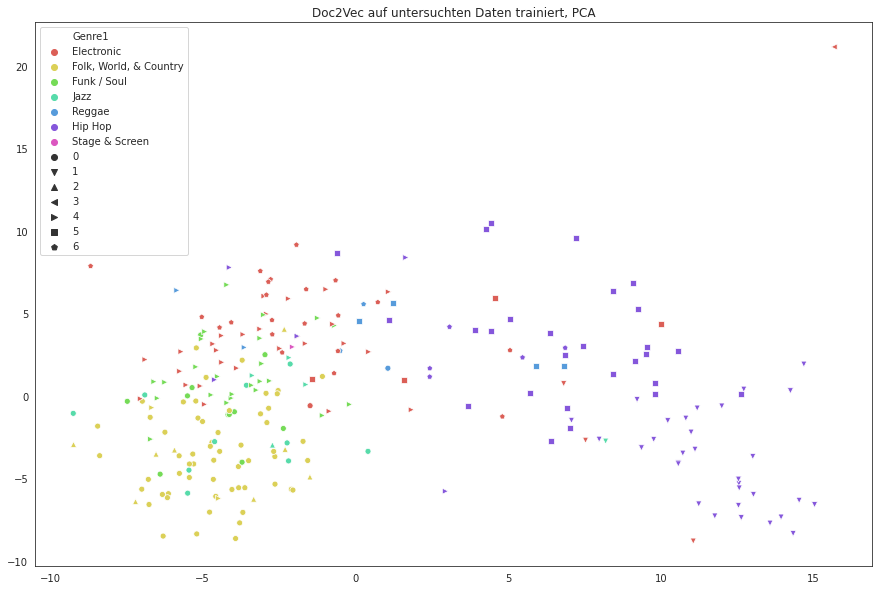

In [197]:
visualise_PCA(Y, songs.Genre1, prediction,'Doc2Vec auf untersuchten Daten trainiert, PCA','/content/d2v_PCA.png')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 254 samples in 0.001s...
[t-SNE] Computed neighbors for 254 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 254 / 254
[t-SNE] Mean sigma: 9.033257
[t-SNE] Computed conditional probabilities in 0.037s
[t-SNE] Iteration 50: error = 45.1436844, gradient norm = 0.0028718 (50 iterations in 0.115s)
[t-SNE] Iteration 100: error = 45.1436806, gradient norm = 0.0000471 (50 iterations in 0.091s)
[t-SNE] Iteration 150: error = 45.1436806, gradient norm = 0.0000016 (50 iterations in 0.077s)
[t-SNE] Iteration 200: error = 45.1301537, gradient norm = 0.0000000 (50 iterations in 0.079s)
[t-SNE] Iteration 200: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 200 iterations with early exaggeration: 45.130154
[t-SNE] Iteration 250: error = 0.9355034, gradient norm = 0.0114717 (50 iterations in 0.077s)
[t-SNE] Iteration 300: error = 0.8379011, gradient norm = 0.0017211 (50 iterations in 0.102s)
[t-SNE] Iter

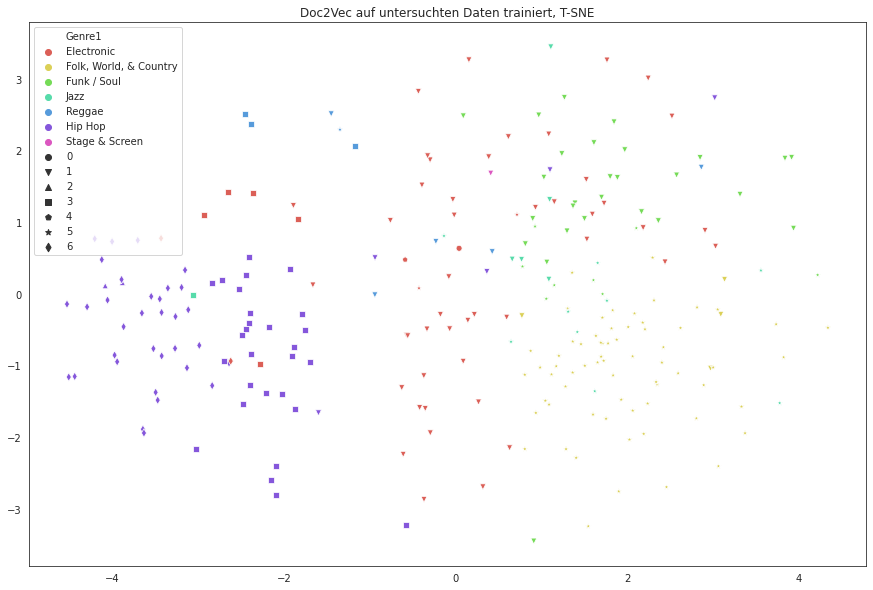

In [112]:
visualise_TSNE(X=X, hue=songs.Genre1, style=prediction,title='Doc2Vec auf untersuchten Daten trainiert, T-SNE',path='/content/d2v_TSNE.png', perplexity=50)

In [205]:
clustered_sentences = [[] for i in range(k)]
for sentence_id, cluster_id in enumerate(kmeans.labels_):
    clustered_sentences[cluster_id].append(list(songs.stemmed_text)[sentence_id])
freq_list=[]
for i, cluster in enumerate(clustered_sentences):
    freqs = {}

    for j in cluster:
       
        indx = list(songs.stemmed_text).index(j)
        topic = songs.iloc[indx]['Genre1']
        if not topic in freqs:
            freqs[topic] = 1
        else:
            freqs[topic] +=1

    freq_list.append(freqs)

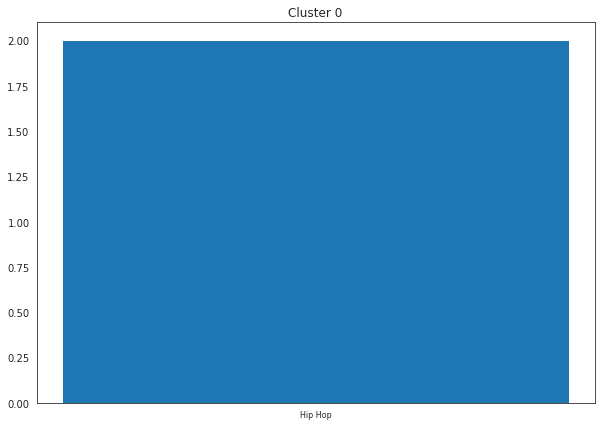

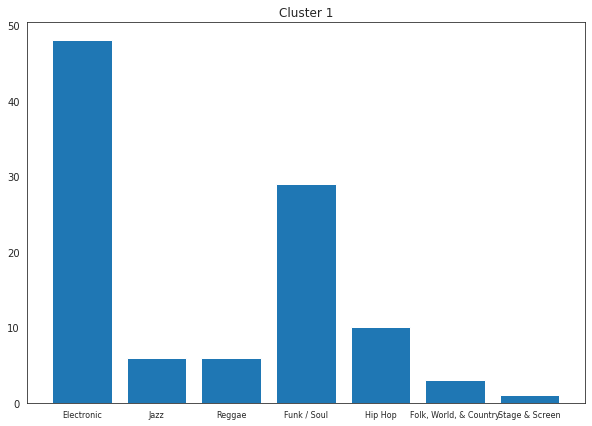

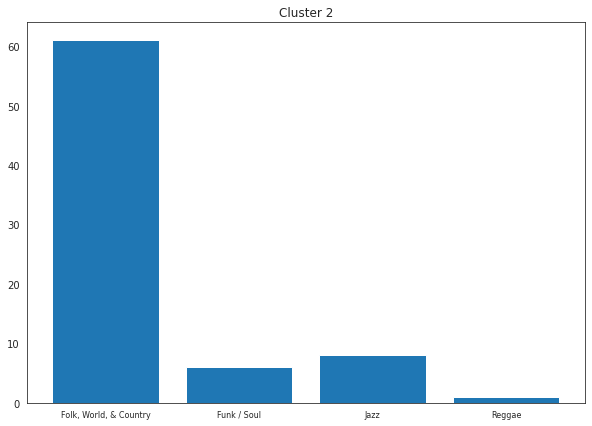

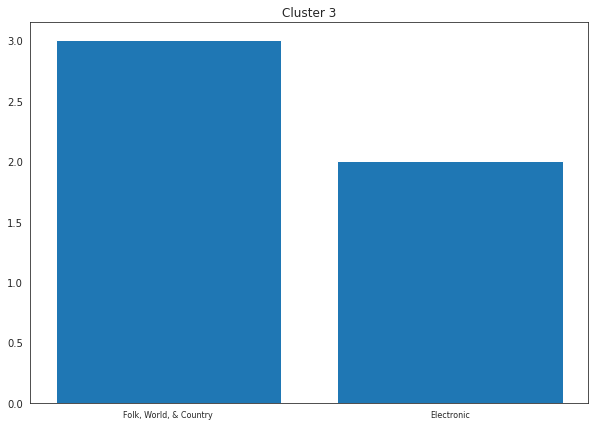

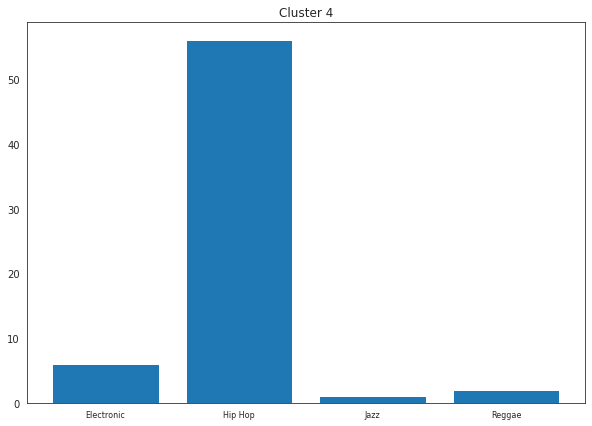

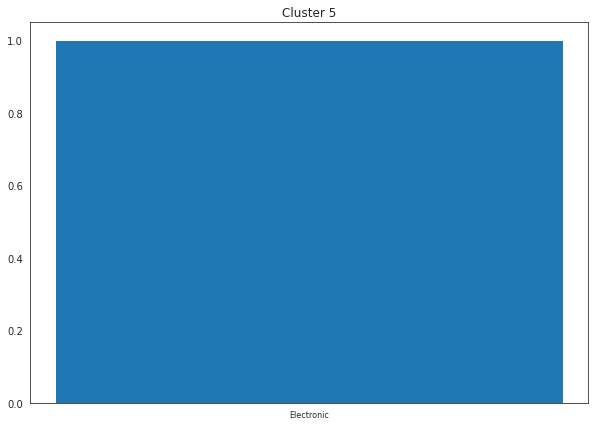

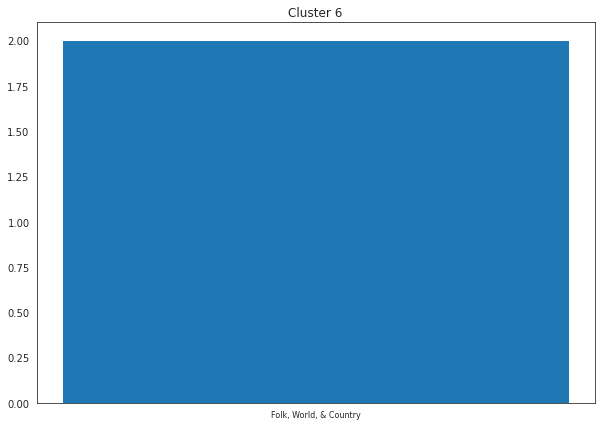

In [215]:
# häufigste Wörter pro Cluster
def hist(freqs):
    i = 0
    for dic in freqs:
        plt.figure(figsize=(10,7))
        plt.bar(list(dic.keys()),dic.values())
        plt.xticks(fontsize=8)
        plt.title('Cluster '+str(i))
        plt.savefig('/content/d2v_all_kmeans_genres_in_cluster'+str(i)+'.png')
        plt.show()
        i +=1

hist(freq_list)

In [218]:
df = pd.DataFrame()
df['Genre'] = songs.Genre1
df['predicted'] = prediction
genre_group = pd.DataFrame(df.groupby('Genre')['predicted'].apply(lambda x: x.value_counts()))
genre_group

predicted
Genre                              
Electronic             4         27
                       1         15
                       5         12
                       2          2
                       6          1
Folk, World, & Country 2         67
                       4          1
                       1          1
Funk / Soul            1         28
                       2          7
Hip Hop                5         32
                       6         21
                       3          9
                       1          3
                       0          3
Jazz                   2         10
                       1          4
                       5          1
Reggae                 5          7
                       2          1
                       1          1
Stage & Screen         1          1

In [219]:
pred_group = pd.DataFrame(df.groupby('predicted')['Genre'].apply(lambda x: x.value_counts()))
pred_group

Genre
predicted                              
0         Hip Hop                     3
1         Funk / Soul                28
          Electronic                 15
          Jazz                        4
          Hip Hop                     3
          Stage & Screen              1
          Reggae                      1
          Folk, World, & Country      1
2         Folk, World, & Country     67
          Jazz                       10
          Funk / Soul                 7
          Electronic                  2
          Reggae                      1
3         Hip Hop                     9
4         Electronic                 27
          Folk, World, & Country      1
5         Hip Hop                    32
          Electronic                 12
          Reggae                      7
          Jazz                        1
6         Hip Hop                    21
          Electronic                  1

In [186]:
# search for certain Genre-Prediction Combinations

# df.reset_index(inplace=True)
# songs.reset_index(inplace=True)
evaluate = []
for i, row in df.iterrows():
  if row.Genre=='Hip Hop' and row.predicted==4:
    evaluate.append(songs.loc[i])
eval = pd.DataFrame(evaluate)
eval.drop('level_0', axis=1, inplace=True)
eval.drop('Unnamed: 0', axis=1, inplace=True)
eval.drop('index', axis=1, inplace=True)
eval.drop('stemmed_text', axis=1, inplace=True)
eval.drop('POS', axis=1, inplace=True)
eval.drop('number_of_tokens', axis=1, inplace=True)
eval.drop('number_of_types', axis=1, inplace=True)
eval.drop('stemmed_split', axis=1, inplace=True)
eval

,artist,decades,text,Genre1,genre1
71,Gucci Mane,2000s,its money mane n' juice man n' gucci mane g...,Hip Hop,atl hip hop
72,Gucci Mane,2010s,two times it's gucci two times zugi zugi b...,Hip Hop,atl hip hop
131,Migos,2010s,intro: quavo pronto pronto pronto pront...,Hip Hop,atl hip hop
240,Yo Gotti,2010s,ion want it ion want it ion want it ion wan...,Hip Hop,dirty south rap


In [200]:
from sklearn import metrics
labels = kmeans.labels_
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
silhouette_score

0.015955035

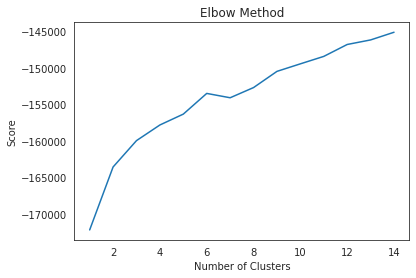

In [201]:
number_clusters = range(1, 15)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

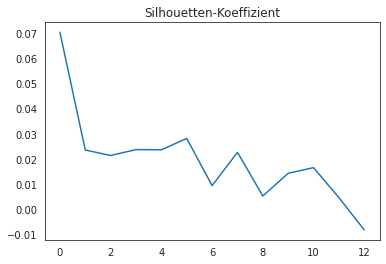

In [202]:
from sklearn.metrics import silhouette_score
metric_silhouette = []
for n in range(1, 15):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    if n > 1:  #silhouette_score needs at least 2 cluster to work
        metric_silhouette.append(silhouette_score(X, kmeans.labels_))

plt.title('Silhouetten-Koeffizient')
plt.plot(metric_silhouette);

## Hierarchisches Clustering

In [90]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

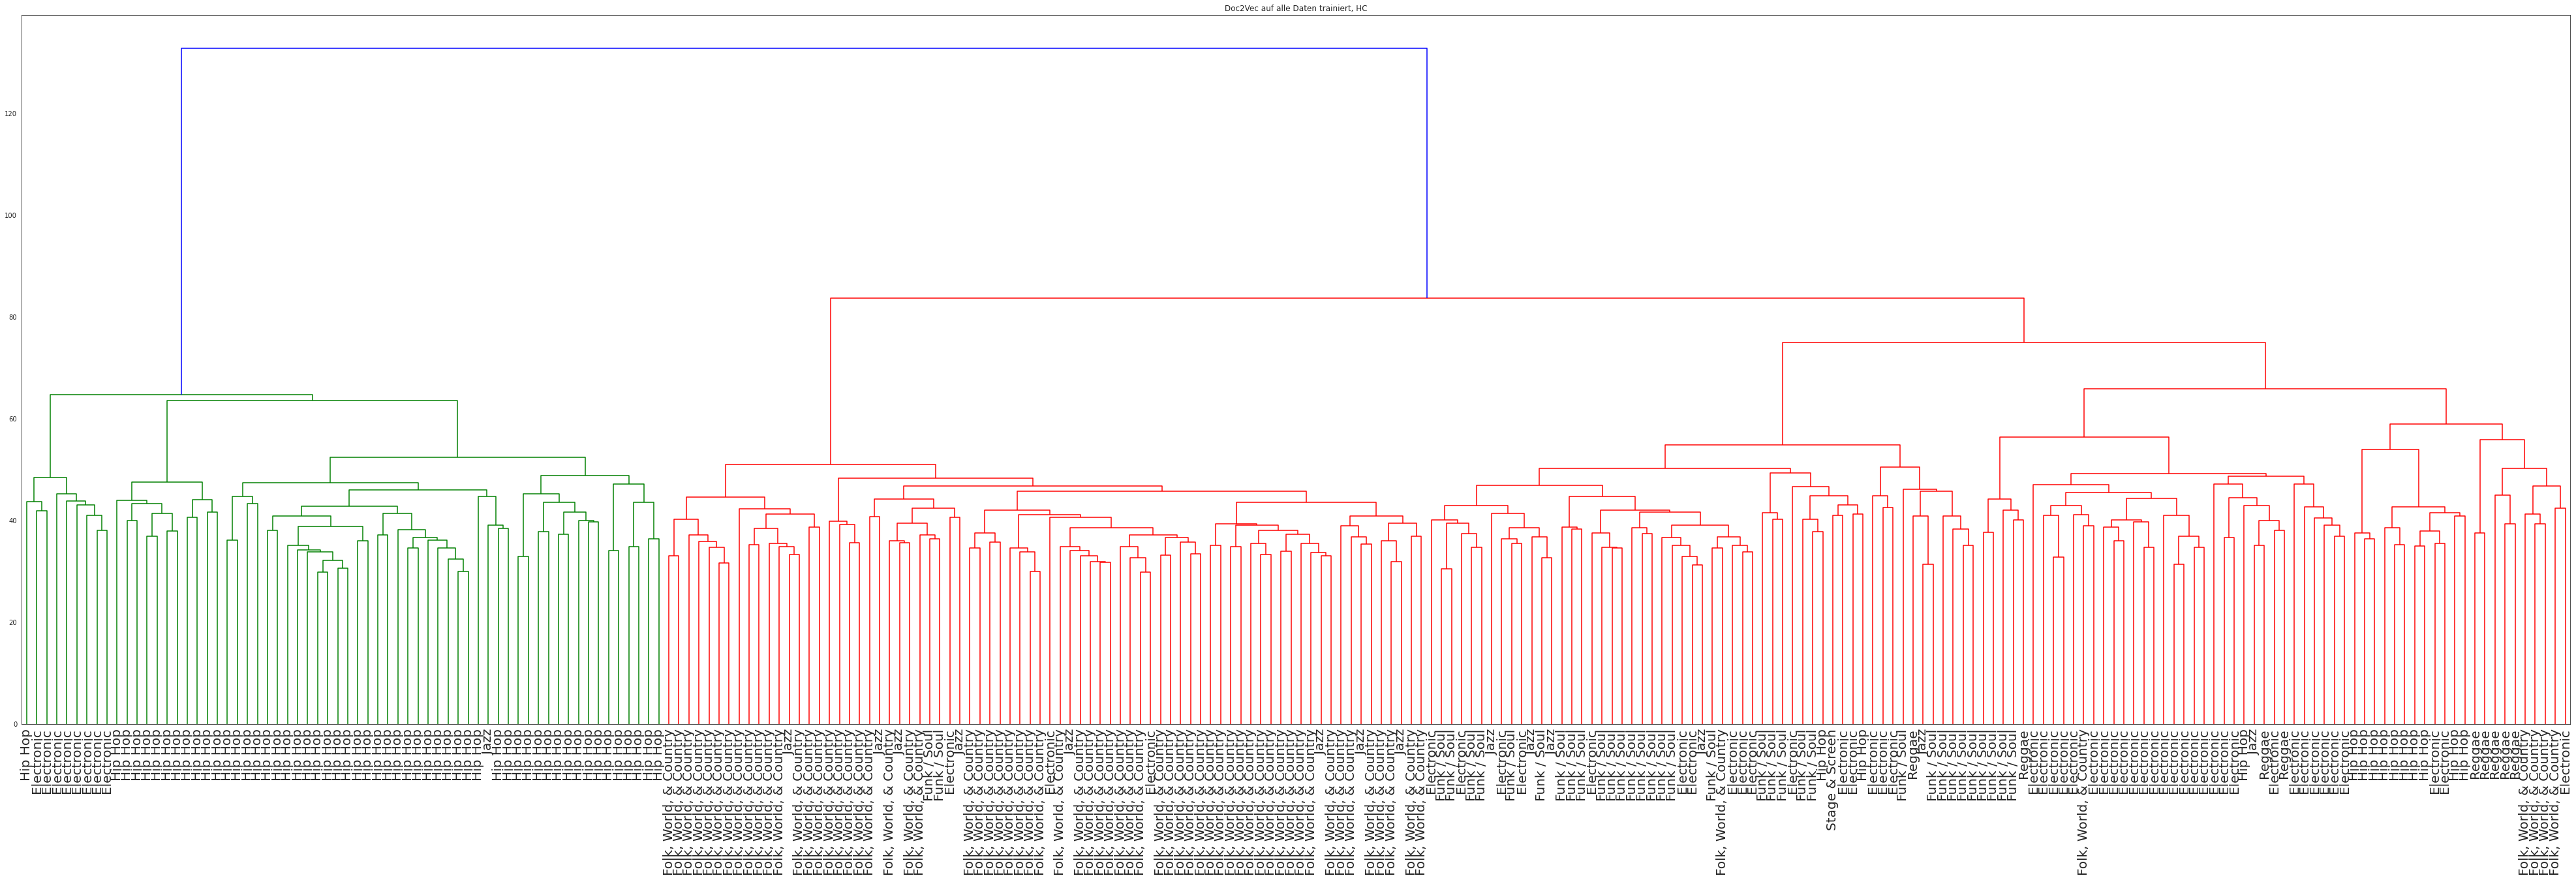

In [187]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X)
link_matrix = linkage_matrix(len(X), model.children_, model.distances_)
plt.figure(figsize=(70,20))
plt.title('Doc2Vec auf alle Daten trainiert, HC')
dendrogram(link_matrix, labels = (songs.Genre1.values), leaf_font_size=20);
plt.savefig('/content/d2v_all_HC.png', bbox_inches = "tight")

In [193]:
ii = itertools.count(X.shape[0])
[{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

NameError: ignored

In [102]:
import random
Y = random.sample(X, 100)

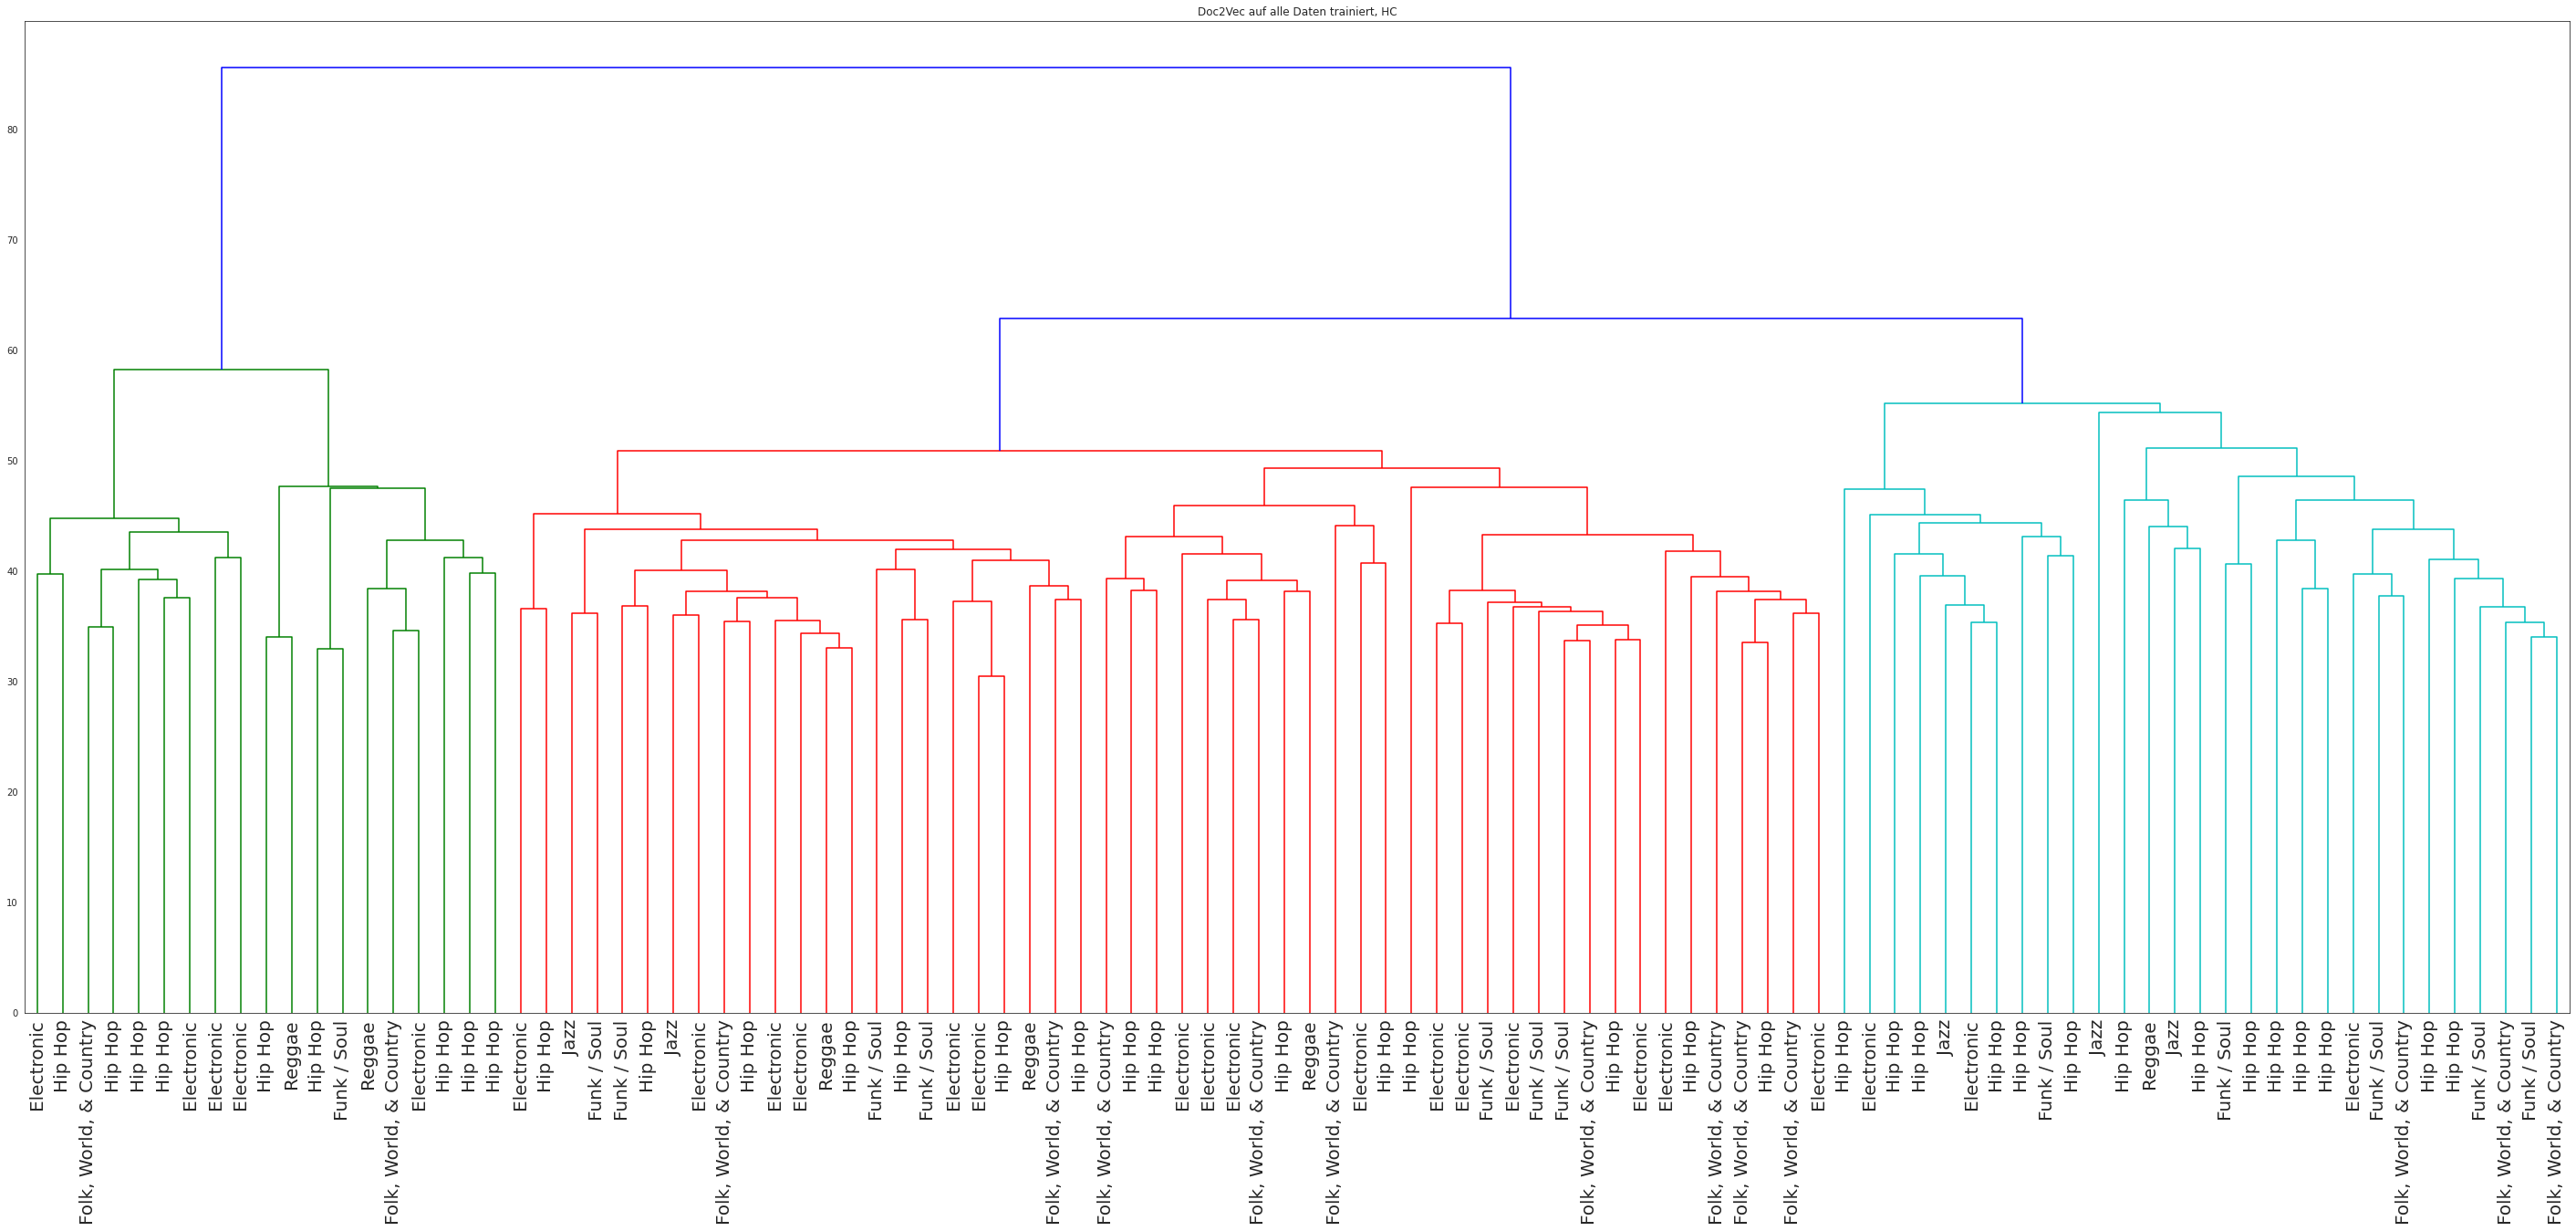

In [103]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(Y)
link_matrix = linkage_matrix(len(Y), model.children_, model.distances_)
plt.figure(figsize=(50,20))
plt.title('Doc2Vec auf alle Daten trainiert, HC')
dendrogram(link_matrix, labels = (songs.Genre1.values), leaf_font_size=20);
plt.savefig('/content/d2v_all_HC_sample.png', bbox_inches = "tight")